# Vechicle detection project

Steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector. 
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Create a heat map of recurring detections to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports and helper functions

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import glob
from IPython import display
from random import randint
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
%matplotlib inline
# %matplotlib qt

In [2]:
# display an image with title
def print_image(image, title = '', grayscale = False):
    fig = plt.figure()
    if not (title == ''):
        plt.suptitle(title + ':')
    if (grayscale):
        plt.imshow(image.squeeze(), cmap = "gray")
    else:
        plt.imshow(image.squeeze())
    plt.show()

In [3]:
# display two images
def print_two_images(img1, img2, title1 = '', title2 = '', grayscale1 = False, grayscale2 = False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if (grayscale1):
        ax1.imshow(img1, cmap = "gray")
    else:
        ax1.imshow(img1)    
    ax1.set_title(title1, fontsize=30)
    
    if (grayscale2):
        ax2.imshow(img2, cmap = "gray")
    else:
        ax2.imshow(img2)    
    ax2.set_title(title2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def print_examples_from_group(images, rows = 1, line_length = 17, grayscale = False):
    for row in range(rows): 
        lane = plt.figure(figsize = (line_length, 1))
        lane.subplots_adjust(hspace = 0, wspace = 0)

        for i in range(line_length):
            index = randint(0, len(images) - 1)
            image = images[index]
            img = cv2.imread(image)
            a = lane.add_subplot(1, line_length, i + 1, xticks=[], yticks=[])
            if (grayscale):
                a.imshow(img.squeeze(), cmap = "gray")
            else:
                a.imshow(img.squeeze())
        plt.show()

# Research
First of all I need to train my model. In order to do it I need:
1. Select model (I used support vector machines classifier).
2. Define features, that will be extracted from the images.
3. Train model on defined features and test it.
4. Find best parameters for the model and feature extraction.

### Prepare data 
First of all, I took training data. I used provided in course set of vechicle and non vechicle images. Lets look on its size and quality.

In [5]:
car_images = glob.glob('train/vehicles/**/*.png')
non_car_images = glob.glob('train/non-vehicles/**/*.png')
print("Vechicle images:     ", len(car_images))
print("Non vechicle images: ", len(non_car_images))

Vechicle images:      8792
Non vechicle images:  8968


Vechicle images:


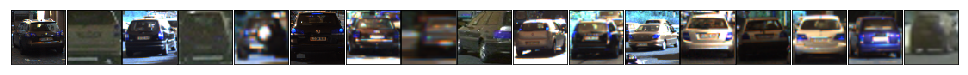

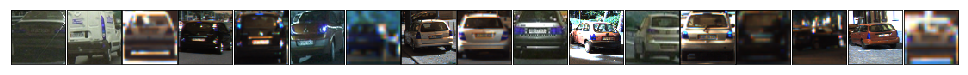

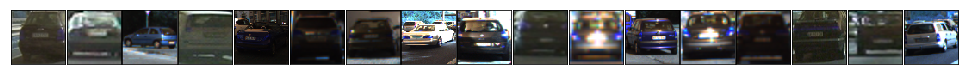

Non vechicle images: 


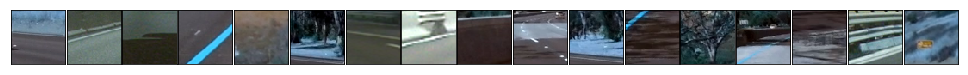

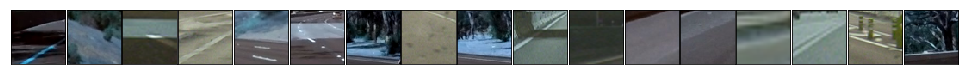

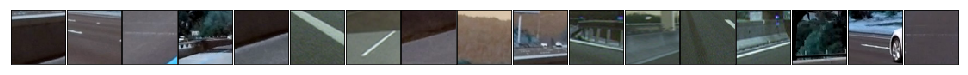

In [6]:
print("Vechicle images:")
print_examples_from_group(car_images, rows = 3)
print("Non vechicle images: ")
print_examples_from_group(non_car_images, rows = 3)

Dataset looks not so big, but may be enough for good detection. 

### HOG
As the next step I want to define features that I want to extract. Firt will be converting of the image to histogram of oriented gradients (HOG), so I want to extract HOG features.
In HOG I can define following parameters:
* amount of orientations
* pixels per cell
* cells per block

For first parameter I used value 9 as supposed in the course. For second and third I need to perform some research. First of all, lets take a look on how HOG features looks like for valies 8 and 8, 4 and 16, 2 and 32, 16 and 4, 32 and 2.

In [7]:
def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 8, vis = False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

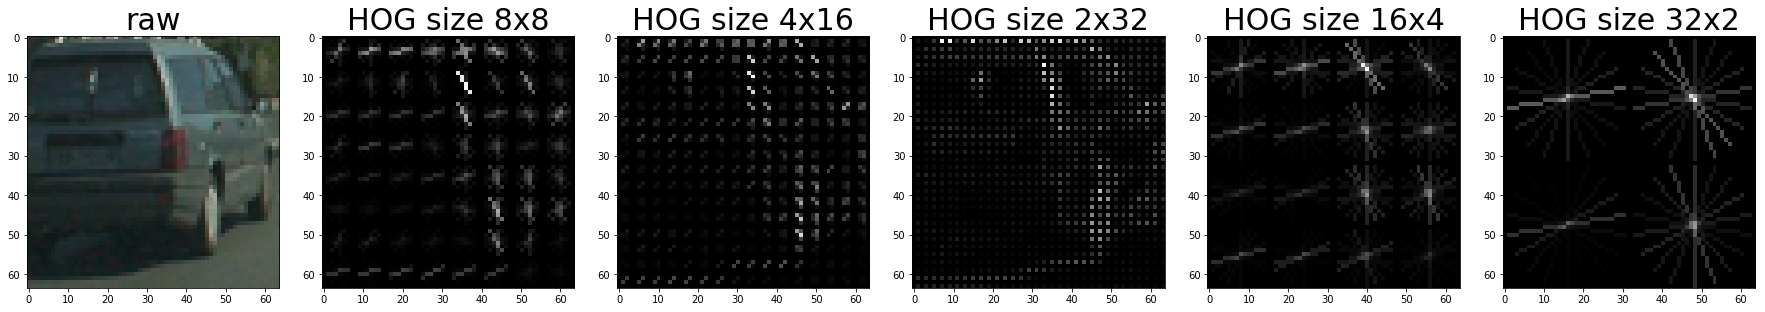

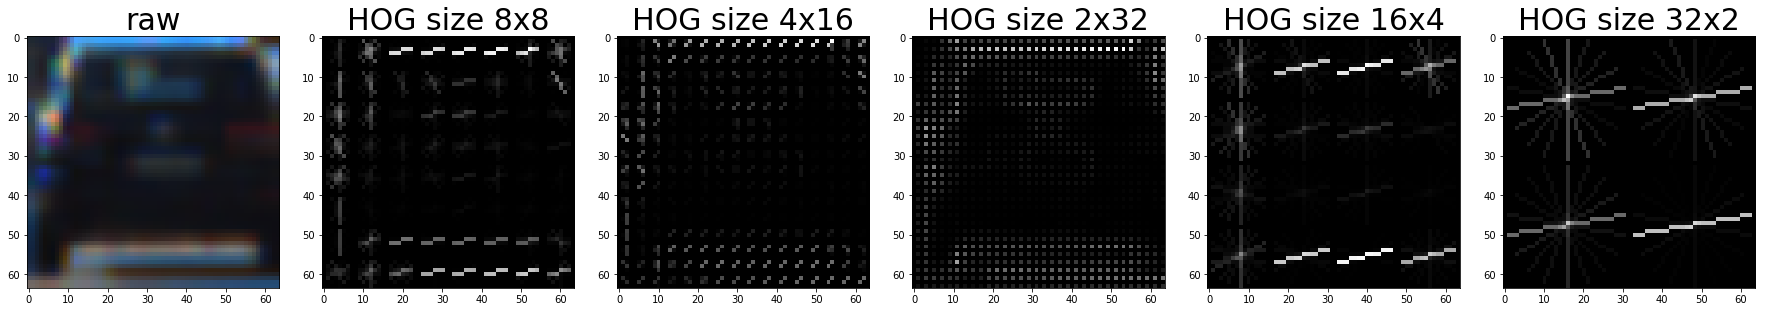

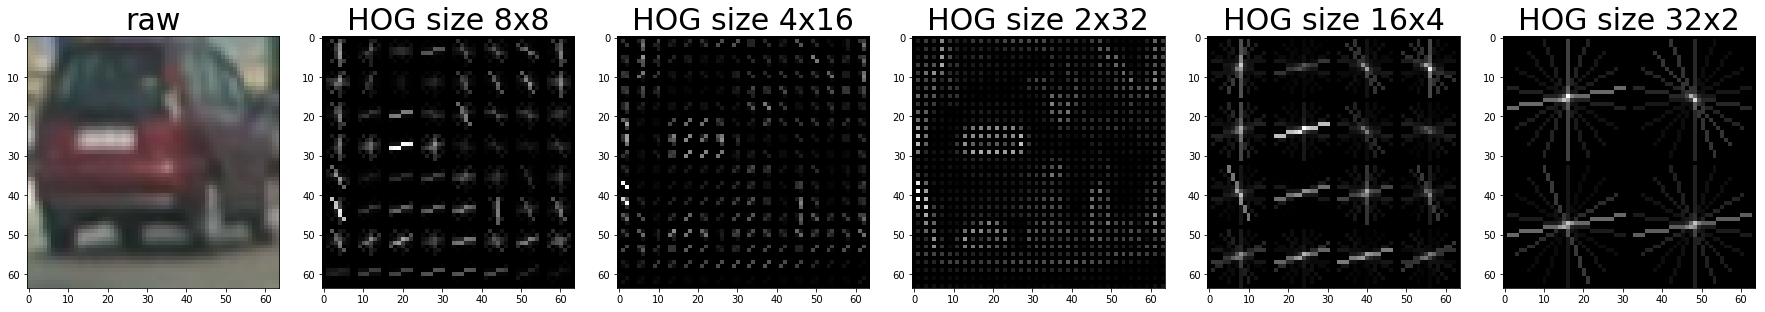

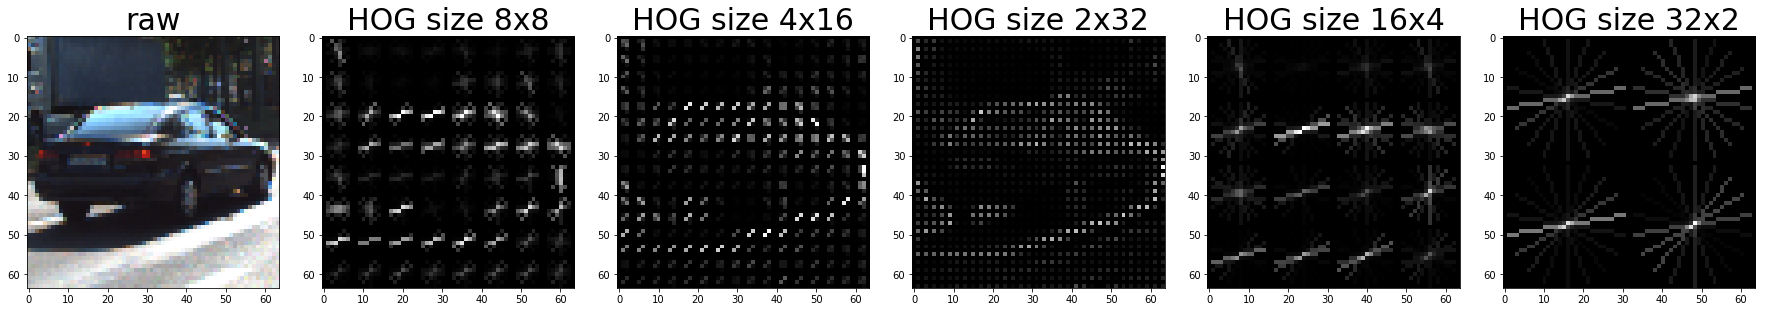

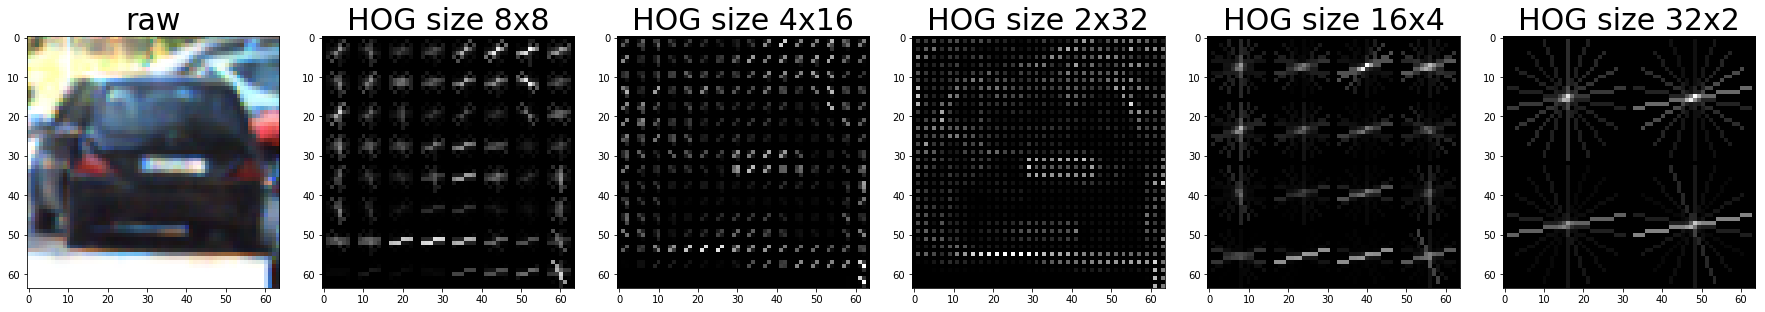

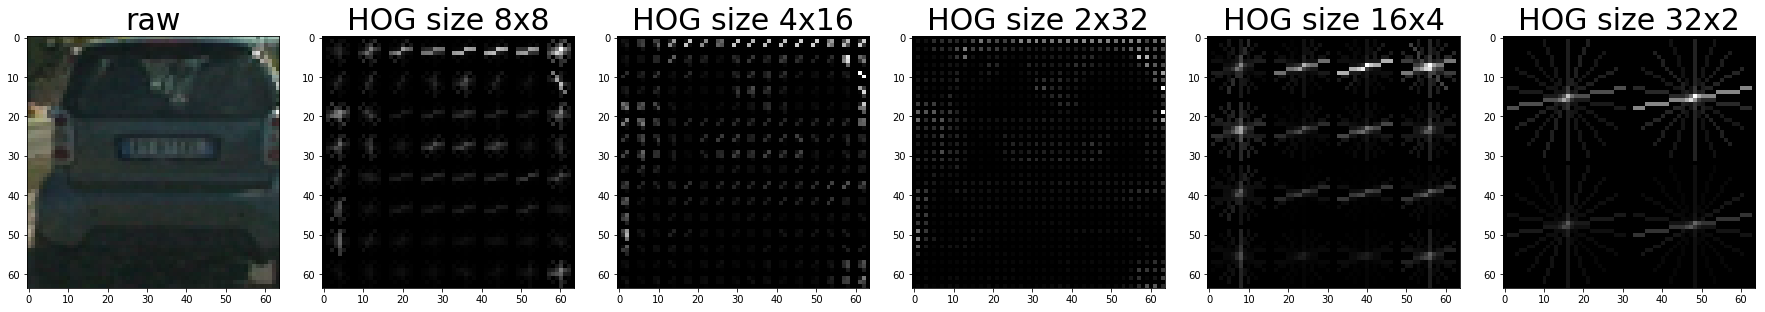

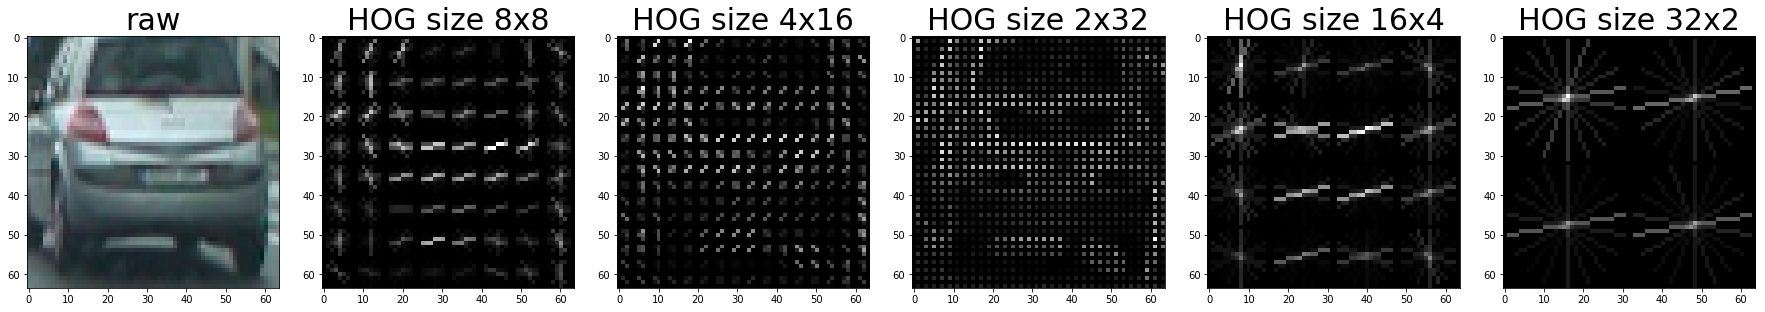

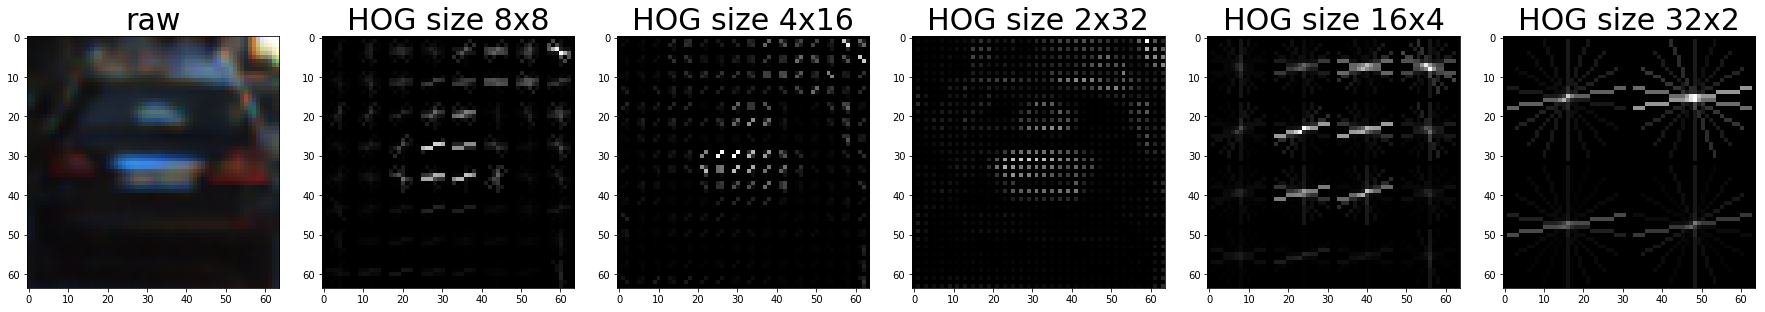

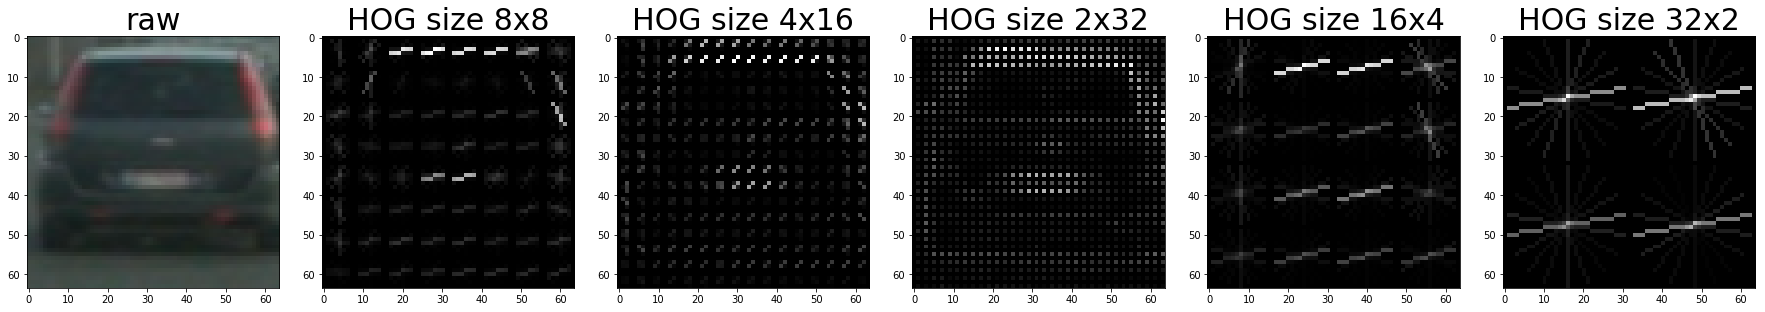

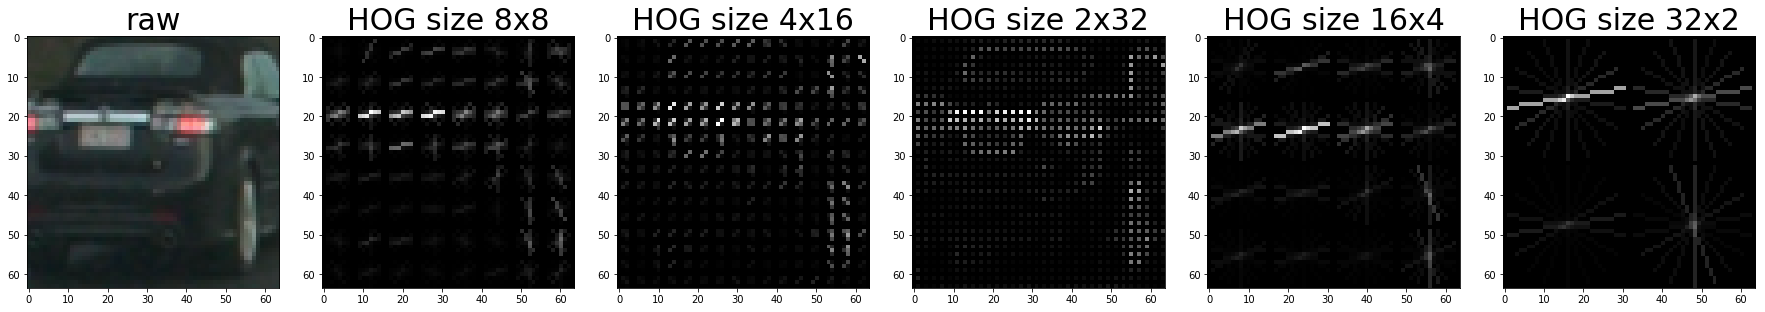

In [8]:
for i in range(10):
    index = randint(0, len(car_images) - 1)

    img = mpimg.imread(car_images[index])
    _, hog_img_8_8 = get_hog_features(img[:,:,2], pix_per_cell = 8, cell_per_block = 8, vis = True)
    _, hog_img_4_16 = get_hog_features(img[:,:,2], pix_per_cell = 4, cell_per_block = 16, vis = True)
    _, hog_img_2_32 = get_hog_features(img[:,:,2], pix_per_cell = 2, cell_per_block = 32, vis = True)
    _, hog_img_16_4 = get_hog_features(img[:,:,2], pix_per_cell = 16, cell_per_block = 4, vis = True)
    _, hog_img_32_2 = get_hog_features(img[:,:,2], pix_per_cell = 32, cell_per_block = 2, vis = True)

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))

    f.tight_layout()
    ax1.imshow(img)    
    ax1.set_title("raw", fontsize=30)

    ax2.imshow(hog_img_8_8, cmap = "gray")    
    ax2.set_title("HOG size 8x8", fontsize=30)

    ax3.imshow(hog_img_4_16, cmap = "gray")    
    ax3.set_title("HOG size 4x16", fontsize=30)

    ax4.imshow(hog_img_2_32, cmap = "gray")    
    ax4.set_title("HOG size 2x32", fontsize=30)

    ax5.imshow(hog_img_16_4, cmap = "gray")    
    ax5.set_title("HOG size 16x4", fontsize=30)

    ax6.imshow(hog_img_32_2, cmap = "gray")    
    ax6.set_title("HOG size 32x2", fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    # print_two_images(trans, grad, "raw", "undistorted", False, True)


Images with parameters (pixels per cell, cells per block) = (8,8), (4,16) and (2,32) looks mode precise from human point of view. (16,4) and (32, 2) are too general from first perspective (but may be also good for detection), while (8,8) gives good vision of the shape of the car, (4,16) and (2,32) gives more car details like car registration number bar and windows.
What will be the best one? Probably, I should not select only one and can concatenate all three features. It may have sense while when we see objects with our eyes, we first extract shape of the object, similar to we could see on image with parameters (8,8) and then look into details, that we could get from the images (4,16) and (2,32).

#### Define color channel for HOG

In the previous example I applied HOG transformation to blue channel of RGB version of the image. But it makes sence to find channels that will give more accurate feature exctraction. Lets see how different channels looks like for train images and what happens when we apply HOG to them.

cspace: RGB, channel: 0


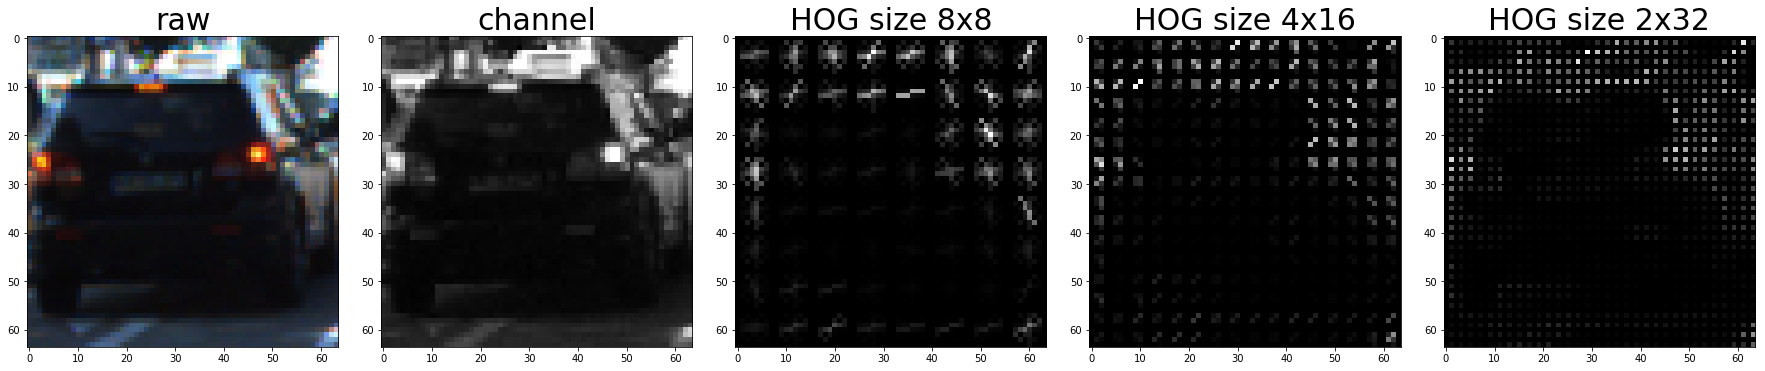

cspace: RGB, channel: 1


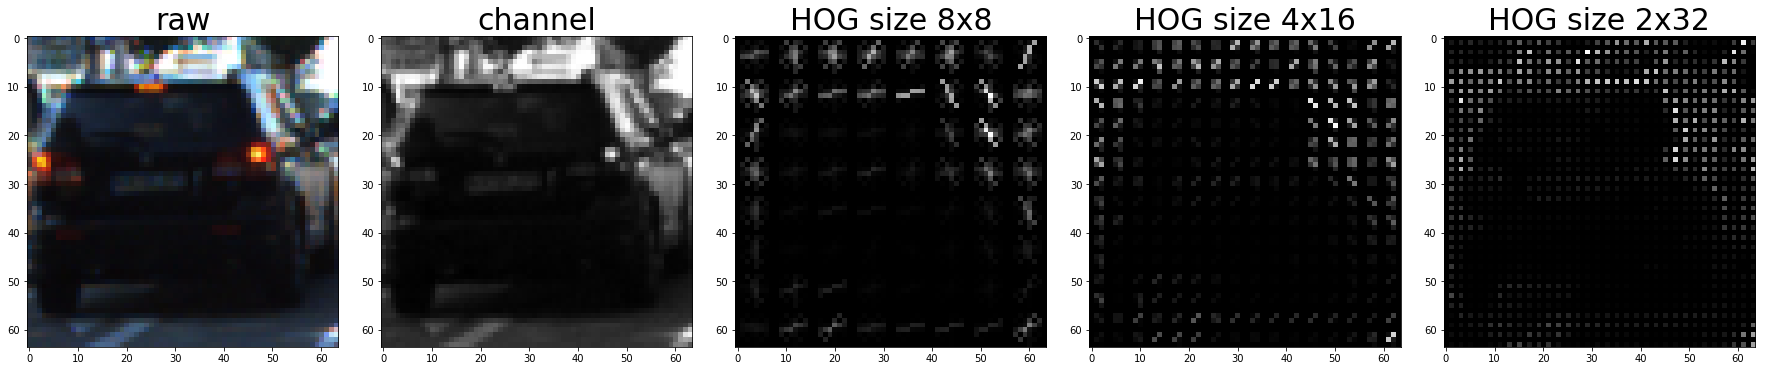

cspace: RGB, channel: 2


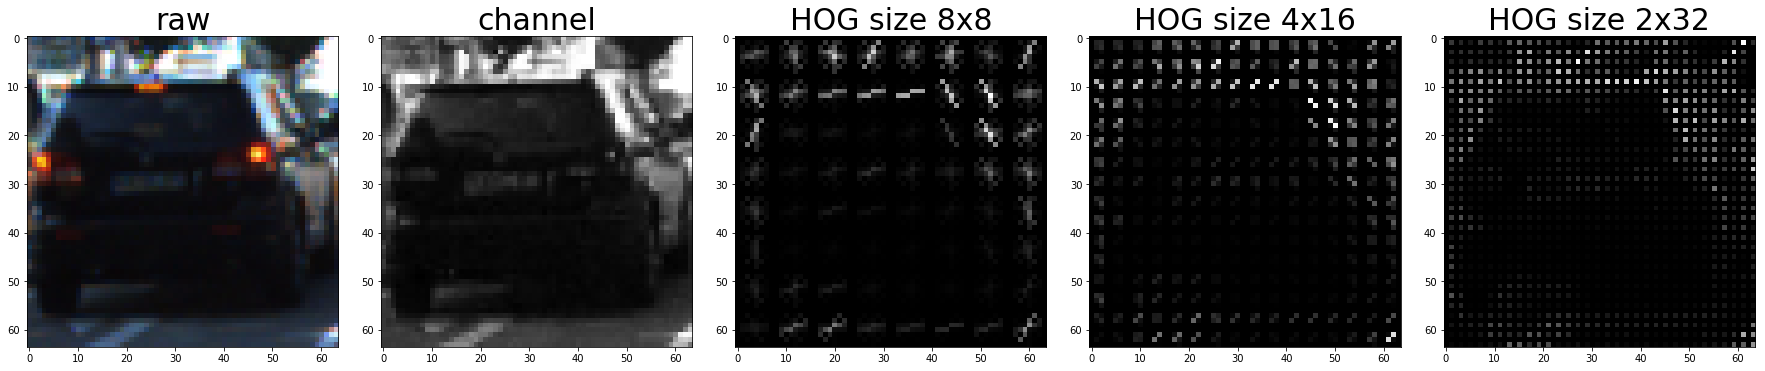

cspace: HSV, channel: 0


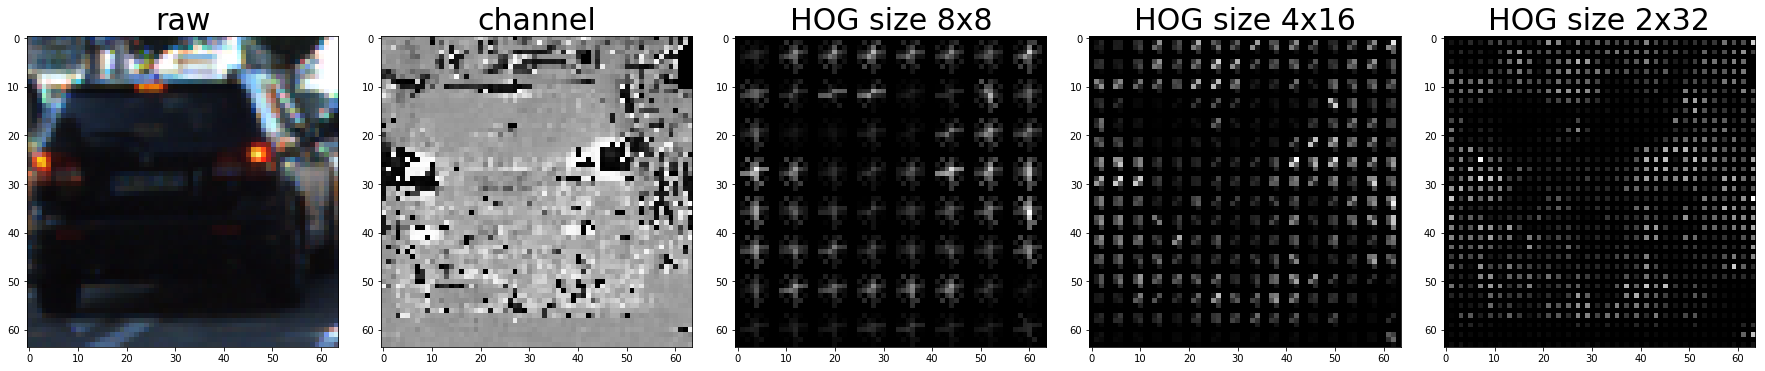

cspace: HSV, channel: 1


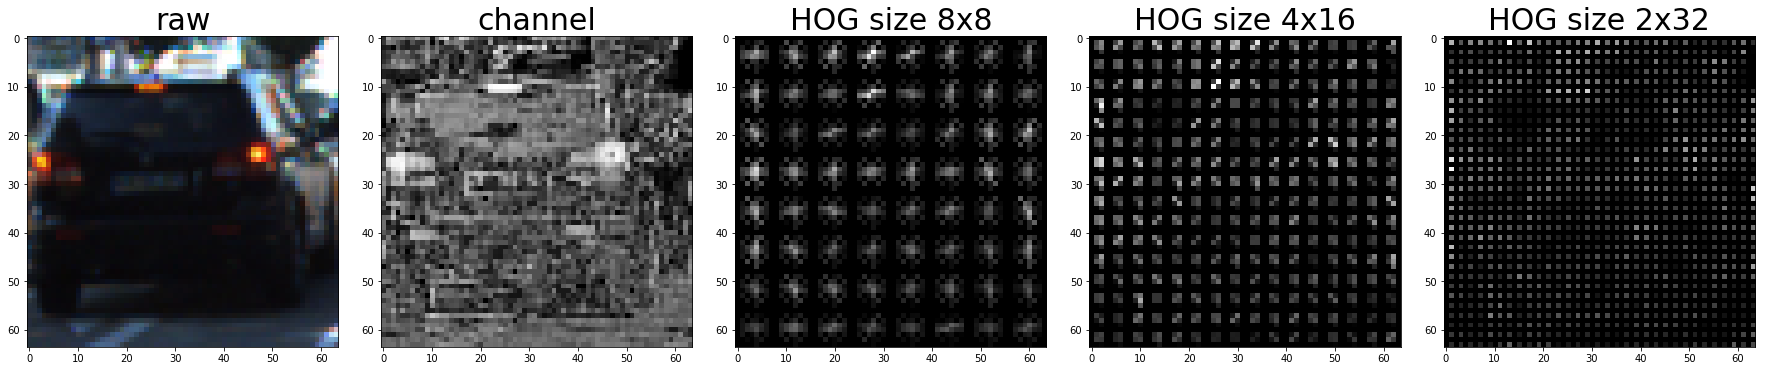

cspace: HSV, channel: 2


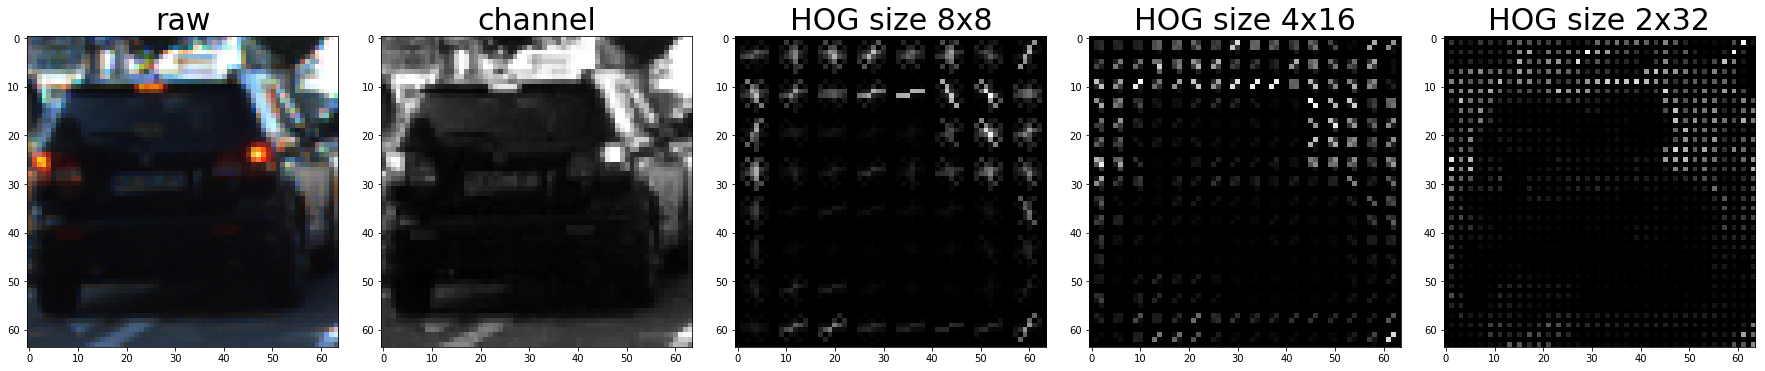

cspace: LUV, channel: 0


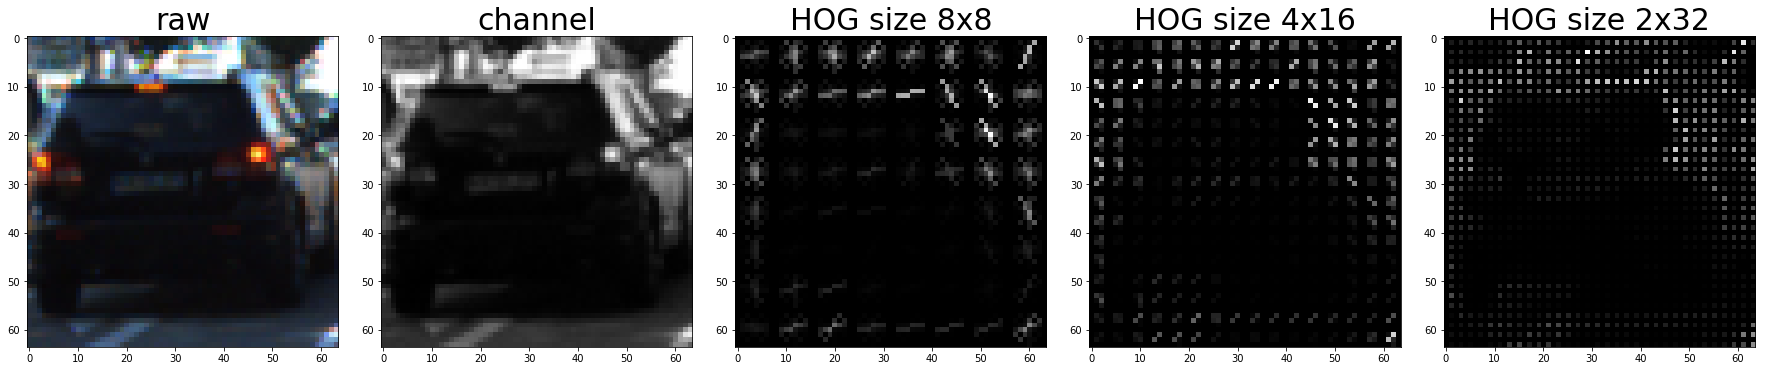

cspace: LUV, channel: 1


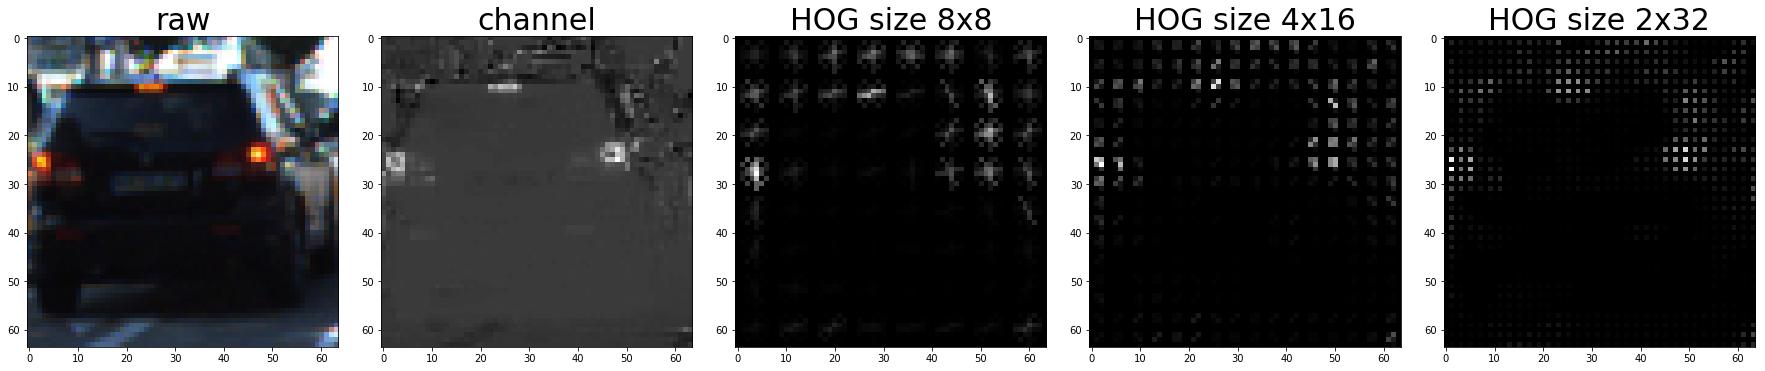

cspace: LUV, channel: 2


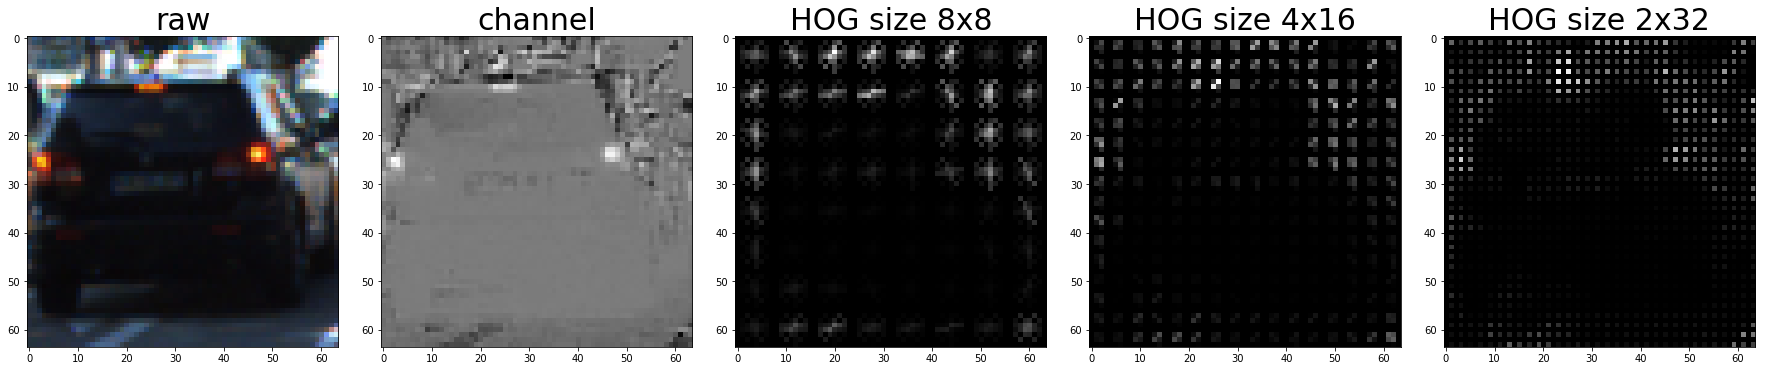

cspace: HLS, channel: 0


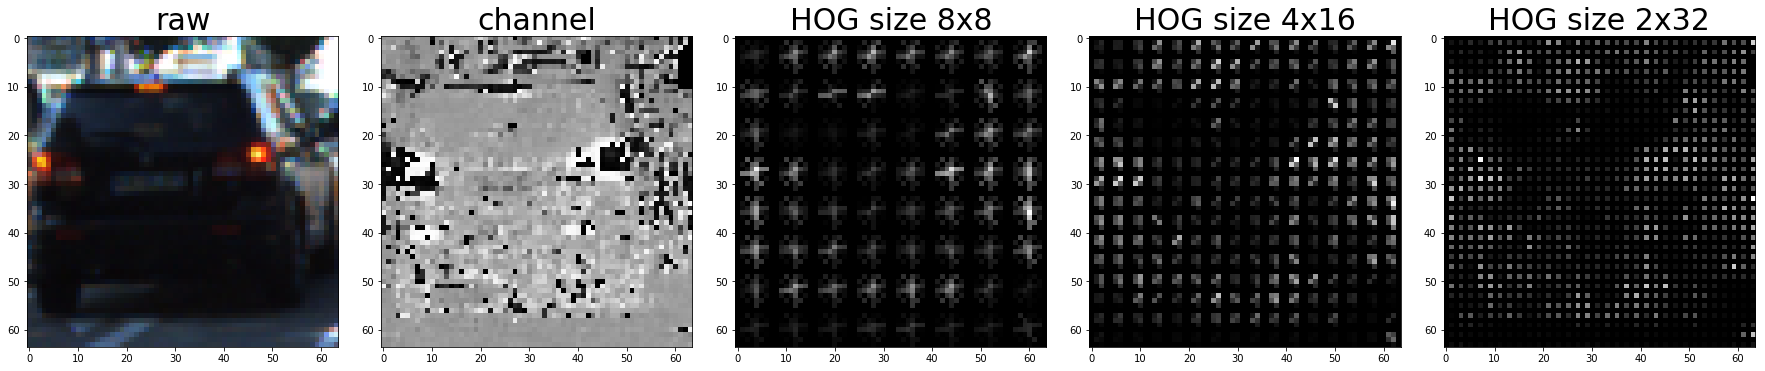

cspace: HLS, channel: 1


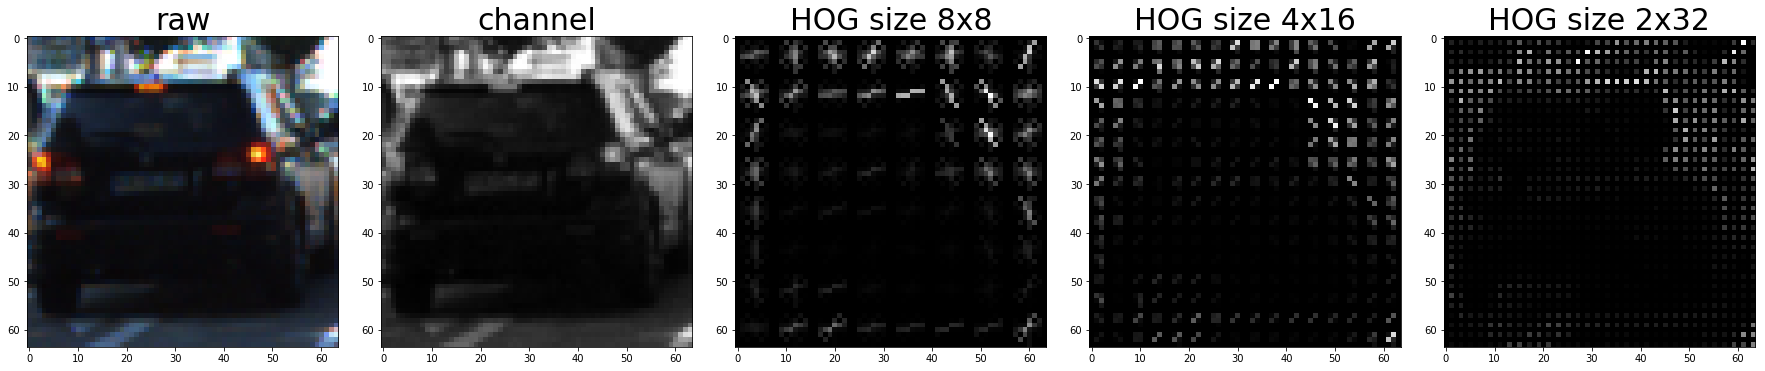

cspace: HLS, channel: 2


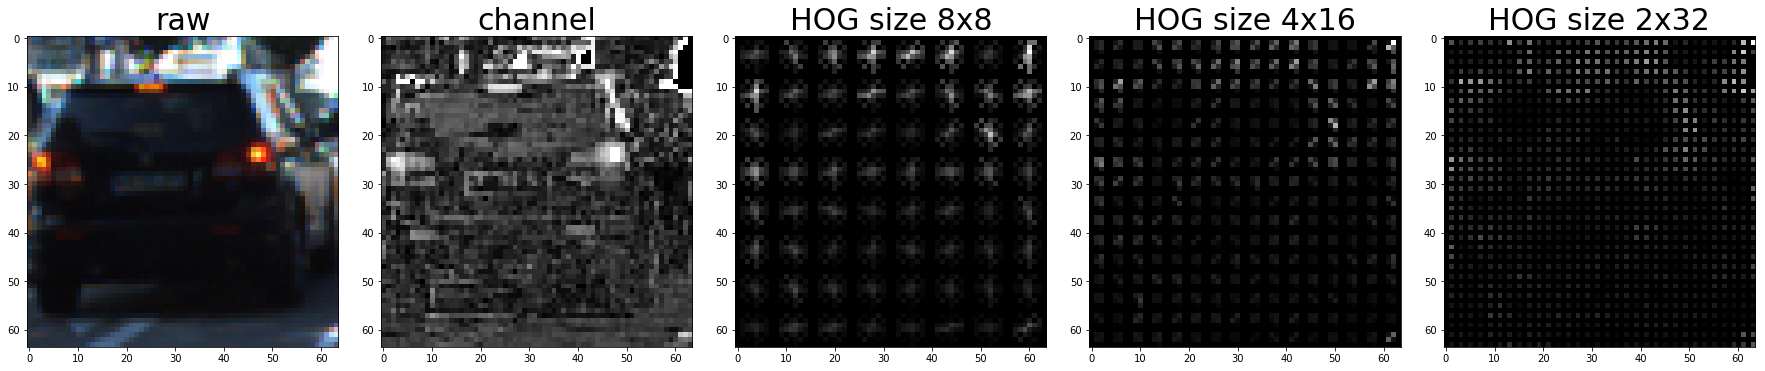

cspace: YUV, channel: 0


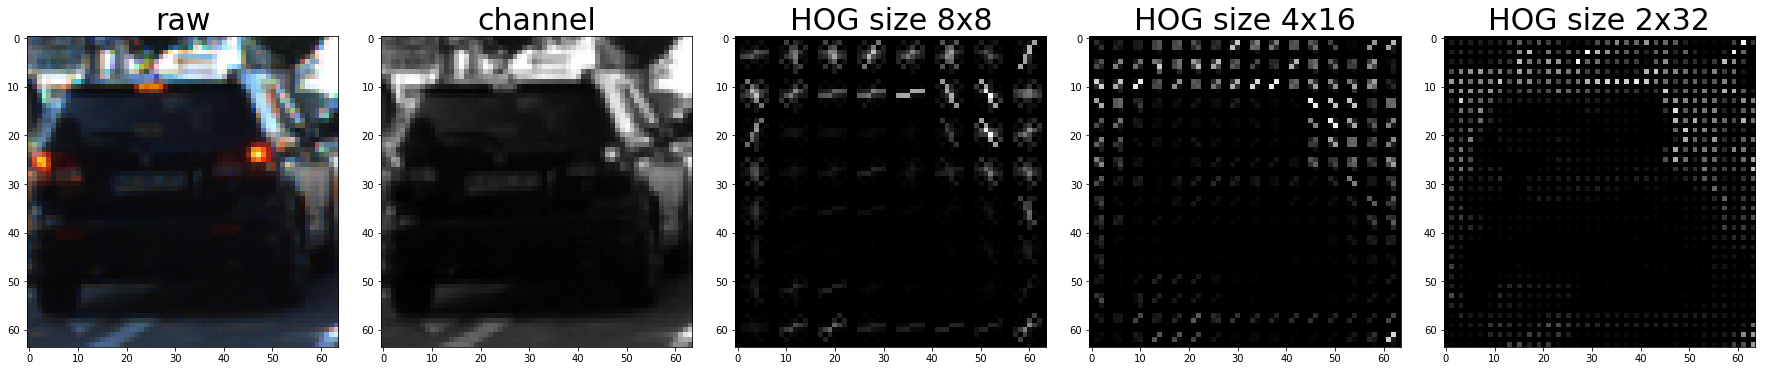

cspace: YUV, channel: 1


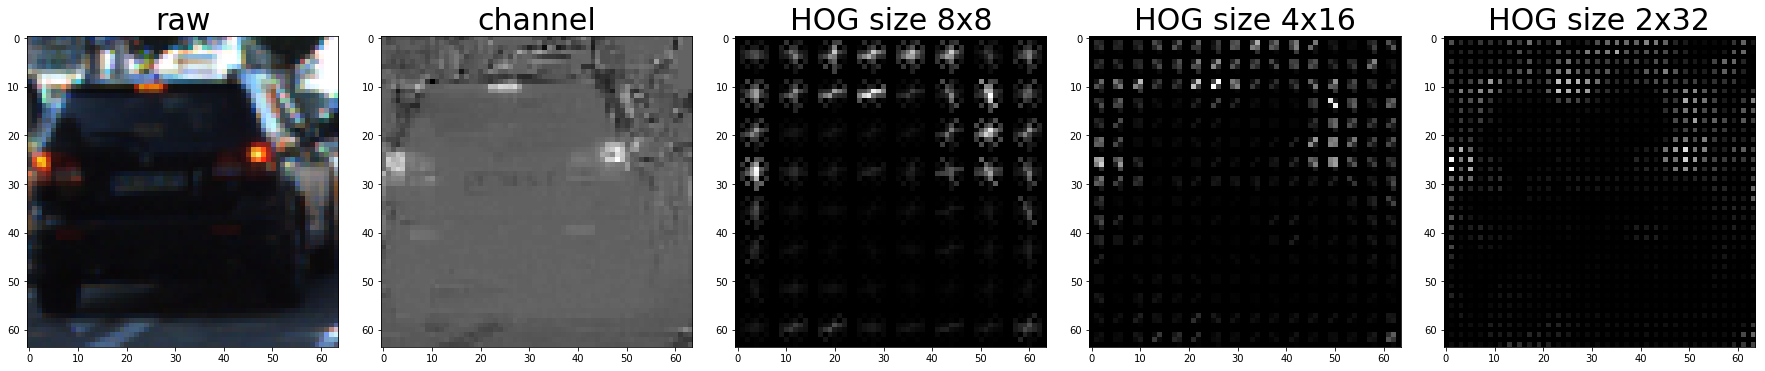

cspace: YUV, channel: 2


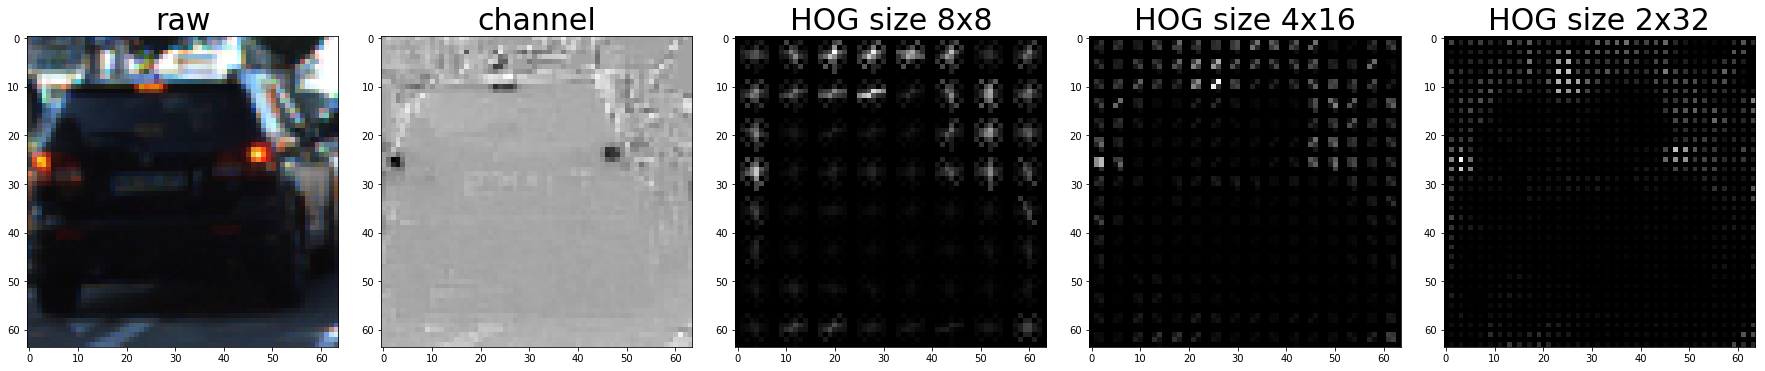

cspace: YCrCb, channel: 0


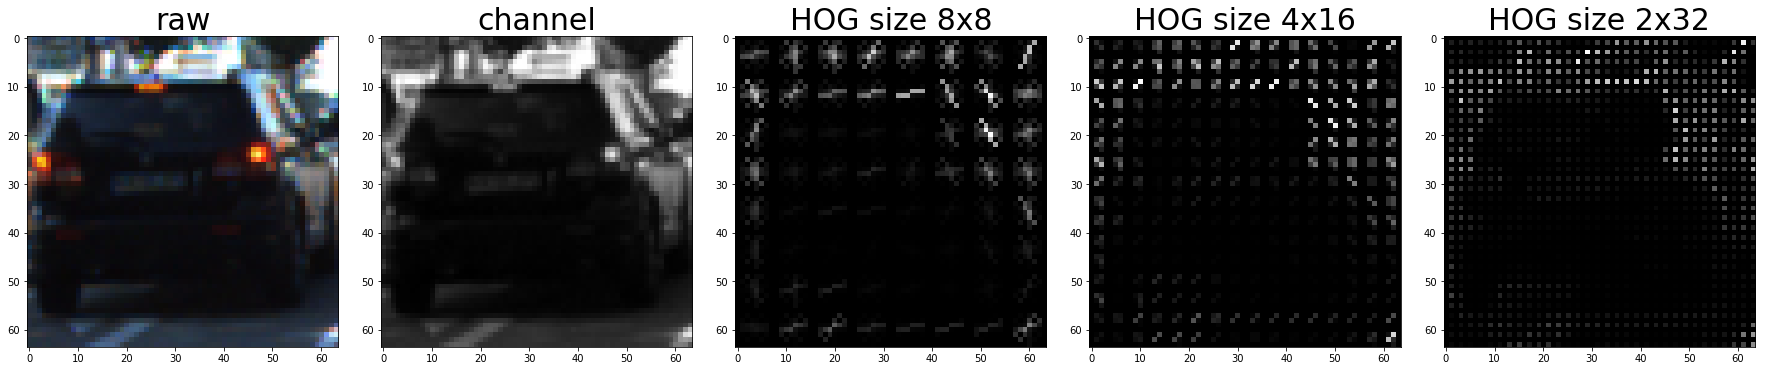

cspace: YCrCb, channel: 1


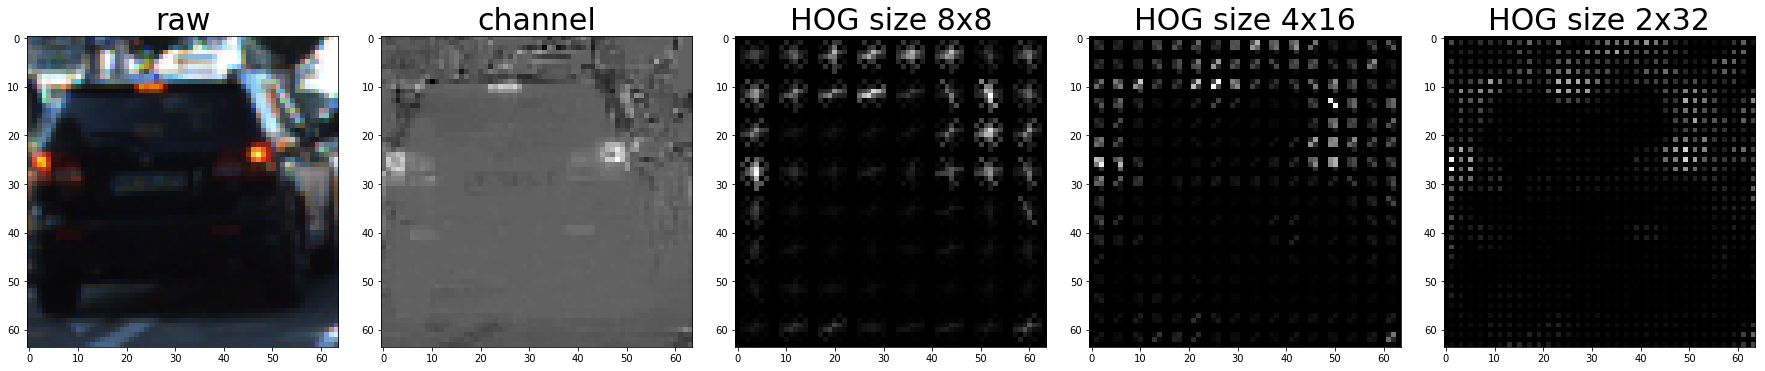

cspace: YCrCb, channel: 2


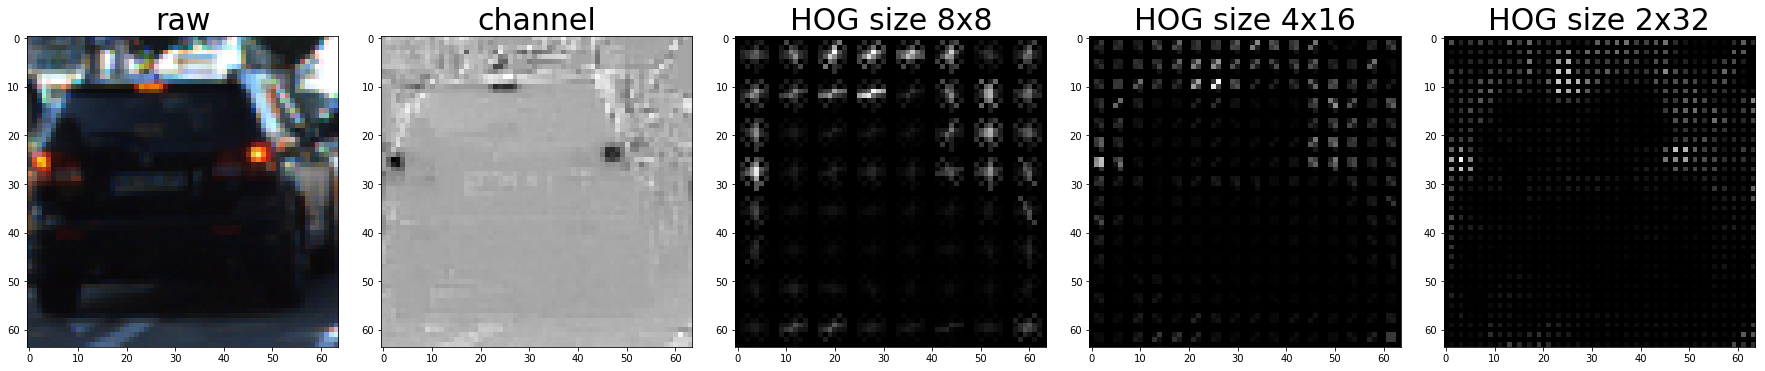

In [9]:
for i in range (1):
    index = randint(0, len(car_images) - 1)

    hog_channels = [0,1,2]
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    for color_space in color_spaces:
        for hog_channel in hog_channels:
            img = mpimg.imread(car_images[index])
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(img)  

            _, hog_img_8_8 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 8, cell_per_block = 8, vis = True)
            _, hog_img_4_16 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 4, cell_per_block = 16, vis = True)
            _, hog_img_2_32 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 2, cell_per_block = 32, vis = True)

            f, (ax1, ax12, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(24, 9))

            f.tight_layout()
            print("cspace: {0}, channel: {1}".format(color_space, hog_channel))
            ax1.imshow(img)    
            ax1.set_title("raw", fontsize=30)

            ax12.imshow(feature_image[:,:,hog_channel], cmap = "gray")    
            ax12.set_title("channel", fontsize=30)

            ax2.imshow(hog_img_8_8, cmap = "gray")    
            ax2.set_title("HOG size 8x8", fontsize=30)

            ax3.imshow(hog_img_4_16, cmap = "gray")    
            ax3.set_title("HOG size 4x16", fontsize=30)

            ax4.imshow(hog_img_2_32, cmap = "gray")    
            ax4.set_title("HOG size 2x32", fontsize=30)

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()

We can easily see that on some channels car image is better recognisable and on some worse. But this recognition is made by human, what will our classifier say about it? Lets give it a try!

### More features

I defined a function to compute binned color features and a function to compute color histogram features. I want to see if this features will help me with my model.

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Test the model!
So, now we can test classifier in different colour spaces, with different HOG parameters and with different set of features.

In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='HLS', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = [[8,8]]):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # hog_parameters = [[2,32],[4,16],[8,8]]
            # hog_parameters = [[8,8],[4,16]]
                        
            for cells_comb in hog_parameters:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, cells_comb[0], cells_comb[1], 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                cells_comb[0], cells_comb[1], vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [12]:
hog_channels = [0,1,2,'ALL']
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
for color_space in color_spaces:
    for hog_channel in hog_channels:
        car_features = extract_features(car_images, color_space=color_space,
                                hog_channel=hog_channel,spatial_feat=False, hist_feat=False)
        non_car_features = extract_features(non_car_images, color_space=color_space,
                                hog_channel=hog_channel,spatial_feat=False, hist_feat=False)

        X = np.vstack((car_features, non_car_features)).astype(np.float64)  
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

        X_scaler = StandardScaler().fit(X) 
        scaled_X = X_scaler.transform(X)

        X_train, y_train = shuffle(scaled_X, y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        # Use a linear SVC 
        classifier = LinearSVC()
        # Check the training time for the SVC
        classifier.fit(X_train, y_train)
        # Check the score of the SVC
        print('Test accuracy for SVC with HOG {0} in Color Space {1} = '.format(hog_channel, color_space), 
              round(classifier.score(X_test, y_test), 4))

Test accuracy for SVC with HOG 0 in Color Space RGB =  0.9135
Test accuracy for SVC with HOG 1 in Color Space RGB =  0.9195
Test accuracy for SVC with HOG 2 in Color Space RGB =  0.9222
Test accuracy for SVC with HOG ALL in Color Space RGB =  0.9342
Test accuracy for SVC with HOG 0 in Color Space HSV =  0.8803
Test accuracy for SVC with HOG 1 in Color Space HSV =  0.8435
Test accuracy for SVC with HOG 2 in Color Space HSV =  0.92
Test accuracy for SVC with HOG ALL in Color Space HSV =  0.955
Test accuracy for SVC with HOG 0 in Color Space LUV =  0.9168
Test accuracy for SVC with HOG 1 in Color Space LUV =  0.8902
Test accuracy for SVC with HOG 2 in Color Space LUV =  0.8675
Test accuracy for SVC with HOG ALL in Color Space LUV =  0.944
Test accuracy for SVC with HOG 0 in Color Space HLS =  0.8812
Test accuracy for SVC with HOG 1 in Color Space HLS =  0.917
Test accuracy for SVC with HOG 2 in Color Space HLS =  0.834
Test accuracy for SVC with HOG ALL in Color Space HLS =  0.95
Test acc

In [13]:
# Feature extraction parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_parameters = [[4,16]]

car_features = extract_features(car_images, color_space=color_space, hog_parameters=hog_parameters,
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False)
non_car_features = extract_features(non_car_images, color_space=color_space,hog_parameters=hog_parameters, 
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False)

X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X)

X_train, y_train = shuffle(scaled_X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


for c in range(1, 100, 5):
    # Use a linear SVC 
    classifier = LinearSVC(C = c)
    # Check the training time for the SVC
    classifier.fit(X_train, y_train)
    # Check the score of the SVC
    print('Test accuracy for SVC with C {0} = '.format(c), 
          round(classifier.score(X_test, y_test), 4))

Test accuracy for SVC with C 1 =  0.9398
Test accuracy for SVC with C 6 =  0.9597
Test accuracy for SVC with C 11 =  0.9637
Test accuracy for SVC with C 16 =  0.9662
Test accuracy for SVC with C 21 =  0.968
Test accuracy for SVC with C 26 =  0.9687
Test accuracy for SVC with C 31 =  0.97
Test accuracy for SVC with C 36 =  0.9708
Test accuracy for SVC with C 41 =  0.9714
Test accuracy for SVC with C 46 =  0.972
Test accuracy for SVC with C 51 =  0.9723
Test accuracy for SVC with C 56 =  0.9722
Test accuracy for SVC with C 61 =  0.9727
Test accuracy for SVC with C 66 =  0.973
Test accuracy for SVC with C 71 =  0.9731
Test accuracy for SVC with C 76 =  0.9732
Test accuracy for SVC with C 81 =  0.9738
Test accuracy for SVC with C 86 =  0.9739
Test accuracy for SVC with C 91 =  0.9739
Test accuracy for SVC with C 96 =  0.974


After numerous amount of runs with different parameters I got best results with following parameters:
1. use only HOG features
2. do in YUV color space with all channels
3. use (8,8) + (4,16) HOG parameters
4. parameter C of SupportSVC function around 40

So now I can start with building of my pipeline. During building the pipeline I discovered that proposed combination of HOG parameters does not give me much better results than (4,16), but is much slower, so I tuned it to use only (4,16).

# Pipeline
### 1. Train classifier 
Train classifier. Use LinearSVC from sklearn. I applied StandardScaler method from sklearn to normalize features.

In [14]:
color_space = 'YUV' 
hog_channel = 'ALL'
orient = 9
#hog_parameters = [[8,8], [4,16]]
hog_parameters = [[4,16]]

car_features = extract_features(car_images, color_space=color_space, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = hog_parameters)
non_car_features = extract_features(non_car_images, color_space=color_space, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = hog_parameters)

X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


#print(X.shape)
X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X)

X_train, y_train = shuffle(scaled_X, y)

# Use a linear SVC 
classifier = LinearSVC(C = 40) 
# Train classifier. I do not use test set in this function because I have fixed parameters in the pipeline.
classifier.fit(X_train, y_train) 

LinearSVC(C=40, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 2. Implement sliding window
In order to detect car on the image I implement sliding window function that takes image, size of the window border in pixels, step overlay (step size is window width devided by step overlay), y thresholds (so for smaller windows I can search more in center of the image, when for bigger search in bigger area). I use all width of the image, so I do not need any x thresholds.

In [15]:
def sliding_window(ymin, ymax, window_border, step_overlay, channels, model, hog_parameters, print_all = False):    
    res = []

    channel = channels[0]
    ch_cropped = channel[ymin:ymax,:]

    step_size = round(window_border / step_overlay)
    nxblocks = round(ch_cropped.shape[1] / step_size) - step_overlay + 1
    nyblocks = round(ch_cropped.shape[0] / step_size) - step_overlay + 1  

    for x_step in range(nxblocks):
        for y_step in range(nyblocks):
            ym = y_step*step_size
            xm = x_step*step_size
            #print('y: ', ym, 'x:', xm)
            features = []
            stacked_features = []
                
            for hog_parameter in hog_parameters:
                
                for channel in channels:
                    ch_cropped = np.copy(channel)
                    ch_cropped = ch_cropped[ymin:ymax,:]

                    window_image = ch_cropped[ym:ym+window_border,xm:xm+window_border]
                    #resize?
                    window_resized = cv2.resize(window_image, (64,64))
                    window_features = get_hog_features(window_resized, hog_parameter[0], hog_parameter[1], 
                                                       hog_parameter[2], vis=False, feature_vec=True)
                    #print(len(window_features))
                    #print(window_features)
                    stacked_features.append(window_features) 
                    #print(len(stacked_features))
                    #print(stacked_features)
                    
                    
            stacked_features = np.concatenate(stacked_features).reshape(-1, 1)
            #.reshape(1, -1)  
            #print(stacked_features.shape)
            features.append(stacked_features) 
            features = np.array(features).astype(np.float64)
            #print(len(features))
            X_scaler = StandardScaler().fit(stacked_features) 
            #print(X_scaler)
            scaled_stacked_features = X_scaler.transform(stacked_features)
            #print(scaled_stacked_features)
            # prediction = model.predict(scaled_stacked_features[0].reshape(1, -1))
            prediction = model.predict(np.concatenate(scaled_stacked_features).reshape(1, -1))
            
            #print(prediction)
            if prediction == 1 or print_all:
                res.append(((xm, ym + ymin),(xm + window_border,ym + window_border + ymin)))
                
    return res         

### 3. Get positions of the car on the image
Then I defined main functions to get positions of the car on the image. It containes following steps:
1. Apply general y thresholds for faster work. All following thresholds will be applied inside cropped image.
2. Convert image to YUV color space.
3. Call window functions for all channels with several sizes. I used 6 sizes with different y thresholds and step overlays (look into the code for details).
4. Apply y offset to all found rectangles, so I gat correct y values for non cropped image.
5. Create heatmap from created rectangles
6. Calculate labels from heatmap and draw all that has > than 3 intersects of different rectangles in order to exclude false positives.

In [30]:
def print_rectangles(img, rectangles, color):
    res = np.copy(img)
    for rectangle in rectangles:
        cv2.rectangle(res, rectangle[0], rectangle[1], color, 6)
        
    return res

def shift_rectangles(rectangles, y_offset):
    shifted_rectangles = []
    for rectangle in rectangles:
        ypred0 = rectangle[0][1] + y_offset
        xpred0 = rectangle[0][0]
        ypred1 = rectangle[1][1] + y_offset
        xpred1 = rectangle[1][0]
        shifted_rectangles.append(((xpred0, ypred0),(xpred1, ypred1)))
        
    return shifted_rectangles

def get_heatmap(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap    

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image and final rectangles
    return img, rects

def predict_car_positions(img):  
    ymin = 350
    ymax = 720
    heatmap_threshold = 12
    orient = 9
    #hog_parameters = [[orient, 8, 8],[orient, 4, 16]]
    hog_parameters = [[orient, 4, 16]]
    img_cropped = img[ymin:ymax,:,:]
    
    # scale the image
    # img_scaled = img_cropped.astype(np.float32)/255
    
    img_cspace = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2YUV)
    
    ch1 = img_cspace[:,:,0]
    ch2 = img_cspace[:,:,1]
    ch3 = img_cspace[:,:,2]

    predictions0 = sliding_window(ymin = 0, ymax = 200, window_border = 45, step_overlay = 2, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions1 = sliding_window(ymin = 0, ymax = 200, window_border = 64, step_overlay = 3, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions2 = sliding_window(ymin = 0, ymax = 230, window_border = 90, step_overlay = 3, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions3 = sliding_window(ymin = 0, ymax = 260, window_border = 120, step_overlay = 4, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions4 = sliding_window(ymin = 0, ymax = 300, window_border = 150, step_overlay = 4, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions5 = sliding_window(ymin = 0, ymax = 350, window_border = 180, step_overlay = 5, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions0 = shift_rectangles(predictions0, ymin)
    predictions1 = shift_rectangles(predictions1, ymin)
    predictions2 = shift_rectangles(predictions2, ymin)
    predictions3 = shift_rectangles(predictions3, ymin)
    predictions4 = shift_rectangles(predictions4, ymin)
    predictions5 = shift_rectangles(predictions5, ymin)
    
    img_rect = np.copy(img)
    img_rect = print_rectangles(img_rect, predictions0, (255, 255, 0))
    img_rect = print_rectangles(img_rect, predictions1, (0, 0, 255))
    img_rect = print_rectangles(img_rect, predictions2, (255, 0, 0))
    img_rect = print_rectangles(img_rect, predictions3, (0, 255, 0))
    img_rect = print_rectangles(img_rect, predictions4, (0, 255, 255))
    img_rect = print_rectangles(img_rect, predictions5, (255, 0, 255))

    img_heatmap = np.zeros_like(img[:,:,0])
    img_heatmap = get_heatmap(img_heatmap, predictions0)
    img_heatmap = get_heatmap(img_heatmap, predictions1)
    img_heatmap = get_heatmap(img_heatmap, predictions2)
    img_heatmap = get_heatmap(img_heatmap, predictions3)
    img_heatmap = get_heatmap(img_heatmap, predictions4)
    img_heatmap = get_heatmap(img_heatmap, predictions5)
              
    img_heatmap_th = np.copy(img_heatmap)
    img_heatmap_th[img_heatmap_th <= heatmap_threshold] = 0
    
    labels = label(img_heatmap_th)
    
    res_img, _ = draw_labeled_bboxes(img, labels)
    
    return img_rect, img_heatmap, res_img

### 4. Run on test images

cspace: YUV, channel: ALL


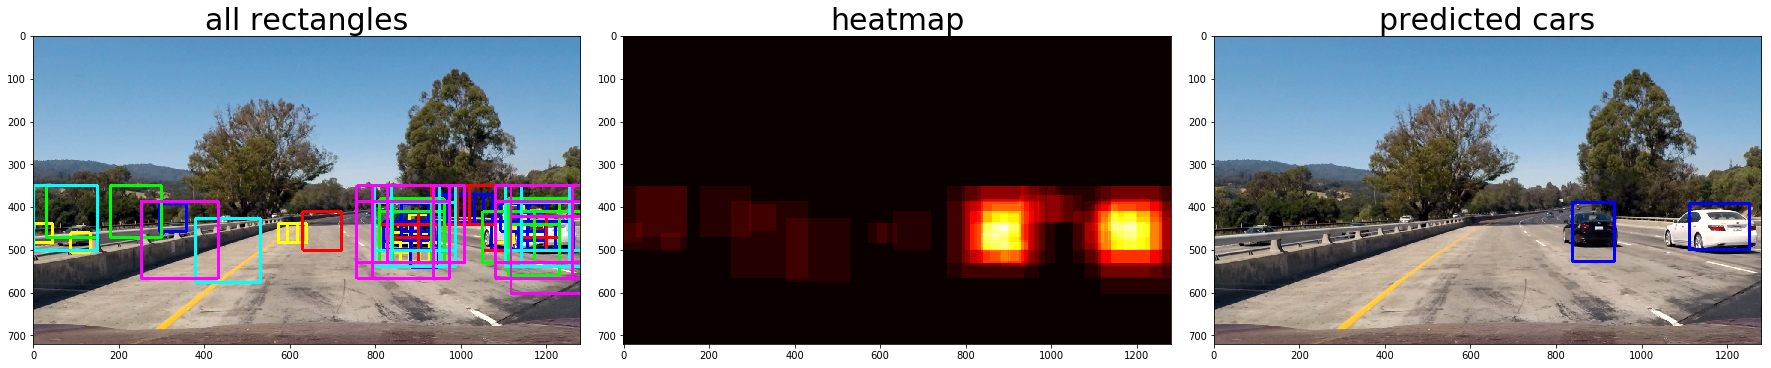

cspace: YUV, channel: ALL


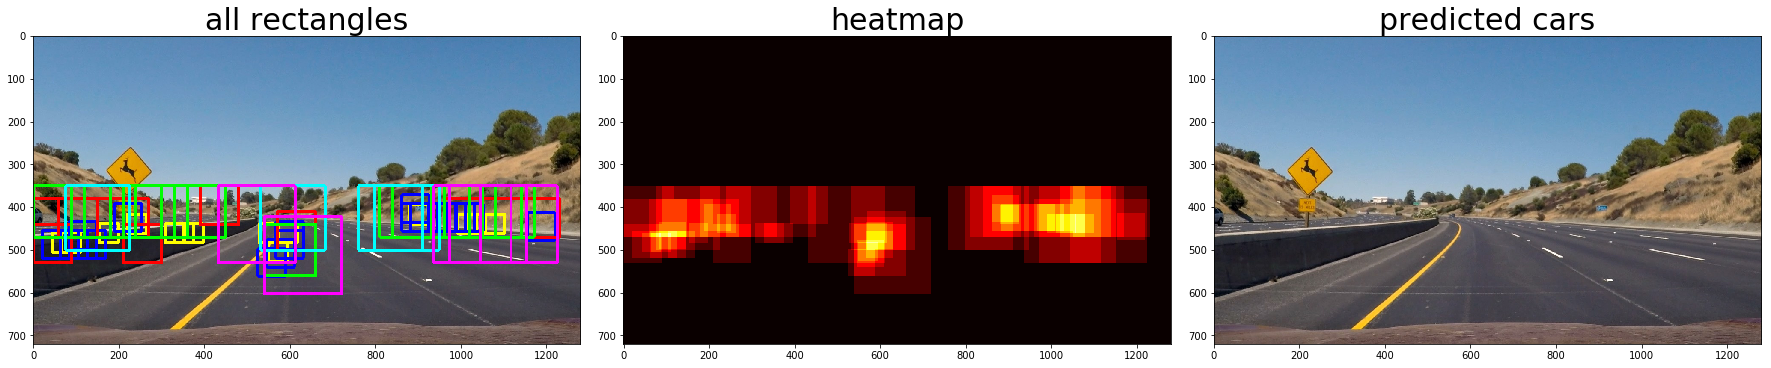

cspace: YUV, channel: ALL


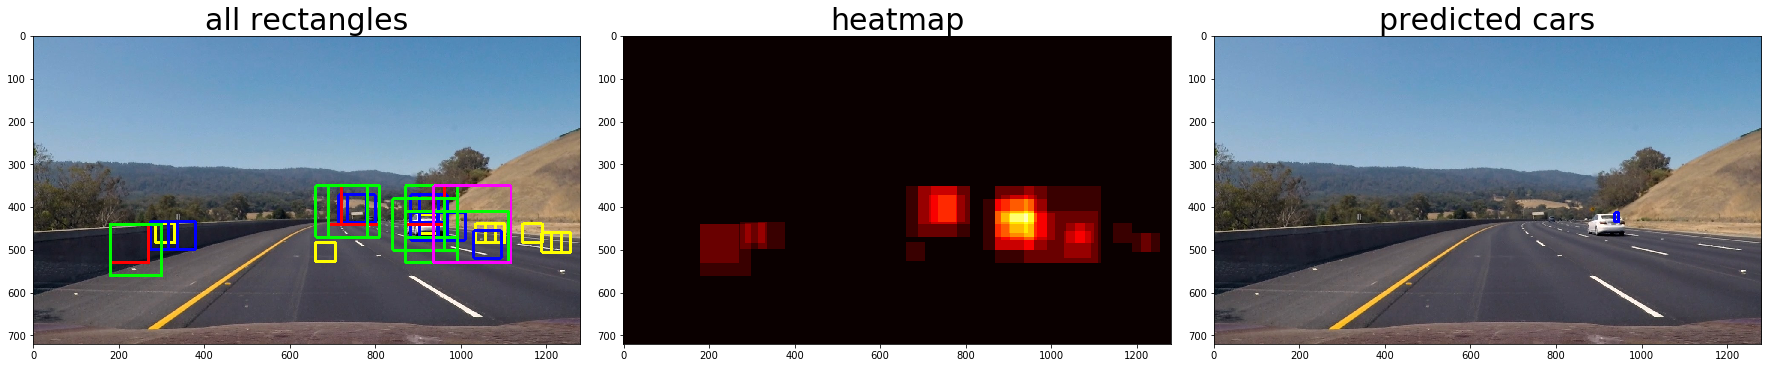

cspace: YUV, channel: ALL


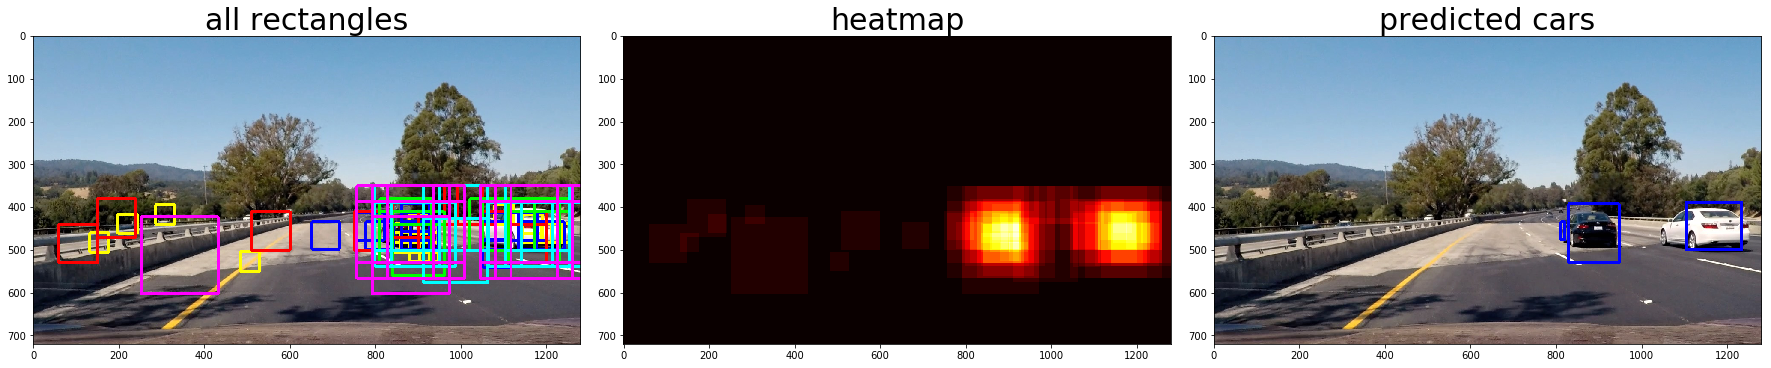

cspace: YUV, channel: ALL


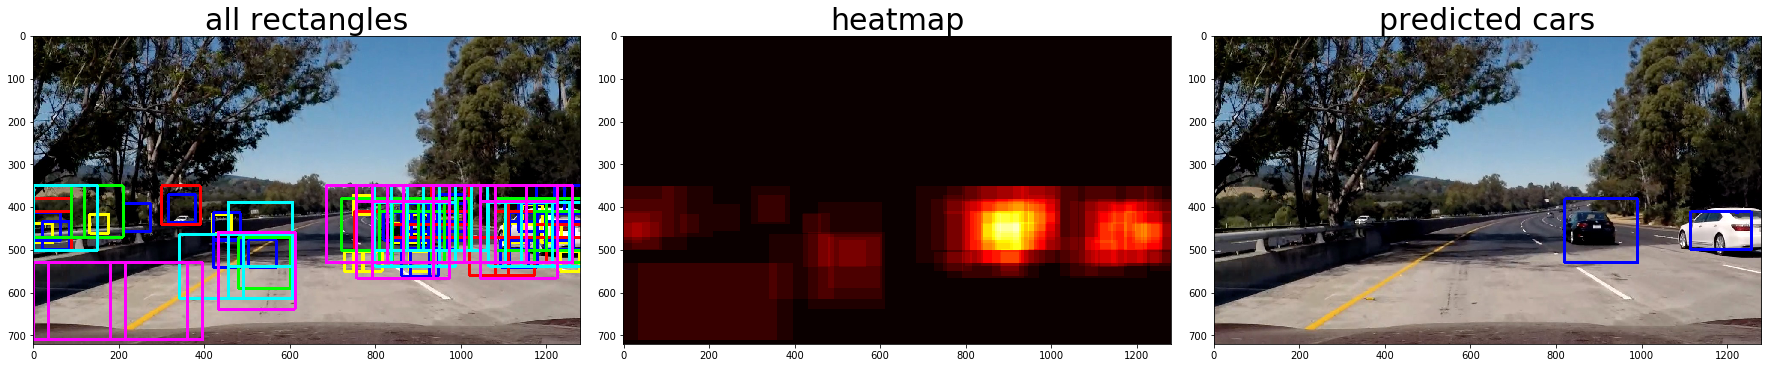

cspace: YUV, channel: ALL


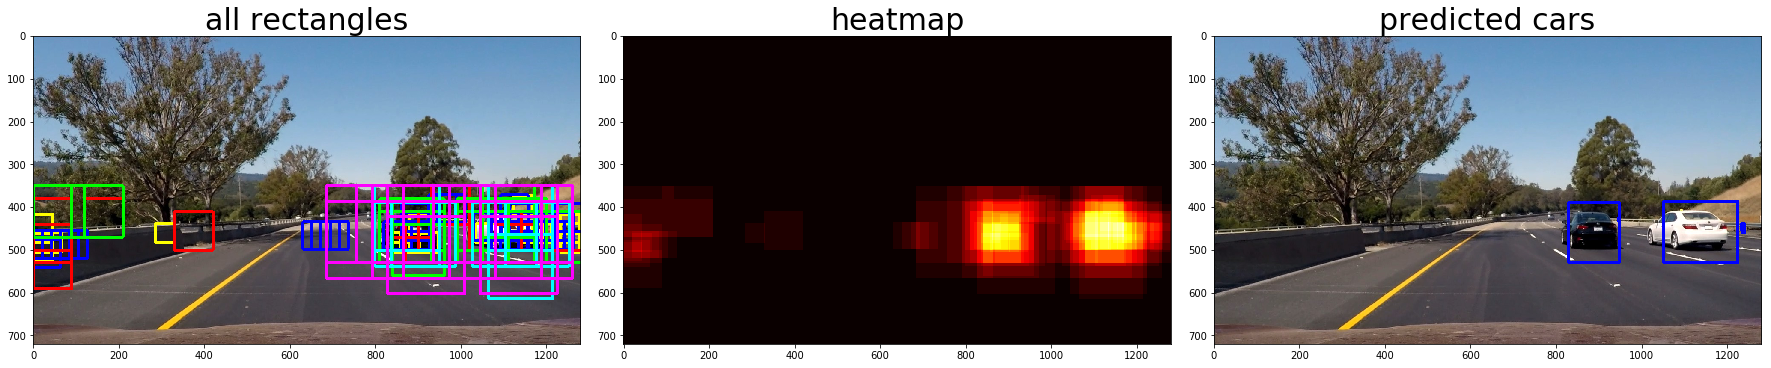

In [31]:
def print_three_images(img1, img2, img3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

    f.tight_layout()
    print("cspace: {0}, channel: {1}".format(color_space, hog_channel))
    ax1.imshow(img1)    
    ax1.set_title("all rectangles", fontsize=30)

    ax2.imshow(img2, cmap = "hot")    
    ax2.set_title("heatmap", fontsize=30)

    ax3.imshow(img3)    
    ax3.set_title("predicted cars", fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

img = mpimg.imread('test_images/test1.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

img = mpimg.imread('test_images/test2.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

img = mpimg.imread('test_images/test3.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

img = mpimg.imread('test_images/test4.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

img = mpimg.imread('test_images/test5.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

img = mpimg.imread('test_images/test6.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

So far looks not bad. The model gives lots of false positives, but I filter them out on the heatmap. Lets see how it works on the video.

In [32]:
def pipeline(img):
    img_rect, img_heatmap, res_img = predict_car_positions(img)
    
    return res_img

## Render videos
### Render sample videos

In [33]:
fname = 'test_video.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip(fname)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4





  0%|          | 0/39 [00:00<?, ?it/s]


  3%|▎         | 1/39 [00:13<08:41, 13.73s/it]


  5%|▌         | 2/39 [00:26<08:16, 13.43s/it]


  8%|▊         | 3/39 [00:38<07:44, 12.91s/it]


 10%|█         | 4/39 [00:50<07:21, 12.60s/it]


 13%|█▎        | 5/39 [01:01<06:56, 12.26s/it]


 15%|█▌        | 6/39 [01:13<06:42, 12.19s/it]


 18%|█▊        | 7/39 [01:25<06:32, 12.26s/it]


 21%|██        | 8/39 [01:38<06:22, 12.33s/it]


 23%|██▎       | 9/39 [01:51<06:18, 12.61s/it]


 26%|██▌       | 10/39 [02:06<06:26, 13.34s/it]


 28%|██▊       | 11/39 [02:20<06:16, 13.44s/it]


 31%|███       | 12/39 [02:33<06:00, 13.36s/it]


 33%|███▎      | 13/39 [02:46<05:43, 13.21s/it]


 36%|███▌      | 14/39 [02:58<05:23, 12.94s/it]


 38%|███▊      | 15/39 [03:11<05:06, 12.79s/it]


 41%|████      | 16/39 [03:23<04:50, 12.64s/it]


 44%|████▎     | 17/39 [03:35<04:36, 12.55s/it]


 46%|████▌     | 18/39 [03:48<04:23, 12.56s/it]


 49%|████▊     | 19/39 [04:00<04:11, 12.55s/it]


 51%|█████▏    

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 



### Render all videos

In [ ]:
fname = 'project_video.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip(fname)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:12<4:19:28, 12.36s/it]


  0%|          | 2/1261 [00:25<4:21:07, 12.44s/it]


  0%|          | 3/1261 [00:37<4:21:09, 12.46s/it]


  0%|          | 4/1261 [00:50<4:23:32, 12.58s/it]


  0%|          | 5/1261 [01:03<4:26:43, 12.74s/it]


  0%|          | 6/1261 [01:16<4:26:45, 12.75s/it]


  1%|          | 7/1261 [01:30<4:35:47, 13.20s/it]


  1%|          | 8/1261 [01:44<4:42:12, 13.51s/it]


  1%|          | 9/1261 [01:57<4:37:13, 13.29s/it]


  1%|          | 10/1261 [02:10<4:33:47, 13.13s/it]


  1%|          | 11/1261 [02:23<4:32:21, 13.07s/it]


  1%|          | 12/1261 [02:36<4:30:51, 13.01s/it]


  1%|          | 13/1261 [02:48<4:29:36, 12.96s/it]


  1%|          | 14/1261 [03:01<4:29:54, 12.99s/it]


  1%|          | 15/1261 [03:14<4:28:25, 12.93s/it]


  1%|▏         | 16/1261 [03:28<4:31:11, 13.07s/it]


  1%|▏         | 17/1261 [03:41<4:32:25, 13.14s/it]


  1%|▏         | 18/1261 [03:55<4:35:57, 13.3